<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/01_Intro_to_Time_Series_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: timeseriesAI@gmail.com

## Purpose 😇

The purpose of this notebook is to show you how you can take any model or dataset in TSAI and run a hyperparameter optimization job to search for combination that yields the best result on the dataset.

## Import libraries 📚

In [1]:
# stable = True # True: latest version, False: stable version
# import sys
# ISCOLAB = 'google.colab' in sys.modules
# if ISCOLAB:
#     if stable: 
#         !pip install tsai -Uqq
#     else:
#         !pip install -Uqq git+https://github.com/timeseriesAI/tsai.git

In [2]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.19
fastai     : 2.5.0
fastcore   : 1.3.26
torch      : 1.9.0+cu102


## Baseline 📉

Before embarking on any hyperparameter optimization tasks, it is important to get a baseline performance so that we can note the improvements after the optimization is done.
In this notebook we use the InceptionTimePlus model and and train on the NATOPS dataset, both conveniently provided in TSAI in just few lines of codes. 
Feel free to use any other models and datasets.

epoch,train_loss,valid_loss,accuracy,time
0,1.666631,1.785262,0.238889,00:00
1,1.354684,1.757811,0.322222,00:00
2,1.071397,1.716692,0.322222,00:00
3,0.890839,1.670404,0.355556,00:00
4,0.776677,1.630869,0.405556,00:00


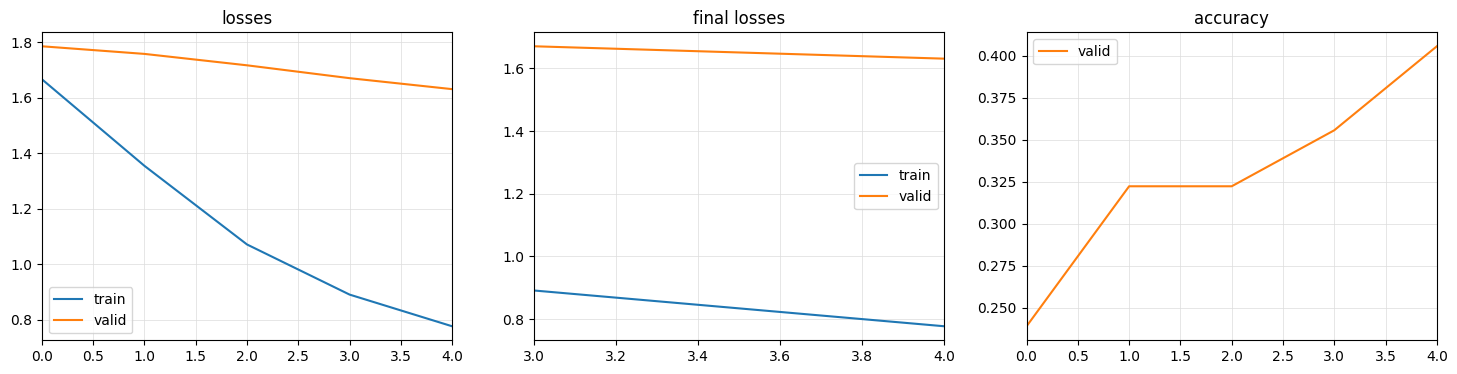

In [23]:
dsid = 'NATOPS' 
X, y, splits = get_UCR_data(dsid, return_split=False)

# Old API
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
model = InceptionTimePlus(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(5, lr_max=1e-3)
learn.plot_metrics()

# New API
# learn = TSClassifier(X, y, splits=splits, bs=[64, 128], batch_tfms=[TSStandardize()], arch=InceptionTimePlus, metrics=accuracy)
# learn.fit_one_cycle(5, lr_max=1e-3)
# learn.plot_metrics()

## Install Optuna 🕹️

[Optuna]('https://optuna.readthedocs.io/en/stable/index.html') is an automatic hyperparameter optimization software framework, particularly designed for machine learning.

In [4]:
# !pip install optuna

## Define objective function 🎯

There are two components in the objective function that you need to define:
1. Search space - the hyperparameter values that you would like to search. In this example we are searching for the combination of nf and dropout rate.
2. Objective value - the value that will be used to indicate the performance of the model. In this example we use the validation loss as the objective value.

In [20]:
import optuna
from optuna.integration import FastAIPruningCallback # A callback to prune unpromising trials (ie early stopping) in Optuna. Optional.

def objective(trial:optuna.Trial):
    
    # Define search space here. Supported search space are 
    num_filters = trial.suggest_categorical('num_filters', [32, 64, 96, 128]) 
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 1.0)

    # Define the model with the search space value
    model = InceptionTimePlus(dls.vars, dls.c, nf=num_filters, fc_dropout=dropout_rate)
    learn = Learner(dls, model, metrics=accuracy, cbs=FastAIPruningCallback(trial))
    learn.fit_one_cycle(5, lr_max=1e-3)
       
    # Return the objective value
    # learn.recorder.values returns [train_loss, valid_loss, metrics] for every epoch.
    return learn.recorder.values[-1][1] # return the validation loss value of the last epoch 

## Start the study 🧑‍🎓

In Optuna, the hyperparameter search job is known as a Study. Each Study consists of many Trials. The number of Trials indicate how many times do you want Optuna to search through the search space.

After configuring the objective function above we would like to let Optuna to perform the search (study) for the combination of hyperparameters that yield the best objective value. 

Note: In the objective function we used the validation loss as our our objective value. Hence in the the study, we must tell Optuna minimize the objective value (This can be specified in the `direction='minimize'` as shown below).

Alternatively, if you chose to use the accuracy metric as the objective value defined in objective function, you will need to tell Optuna to maximize instead. (This can be specified in the `direction='maximi'` )

In [6]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2021-08-10 12:39:57,114] A new study created in memory with name: no-name-c425bea2-bcbe-4549-88ba-d852895e24c6


epoch,train_loss,valid_loss,accuracy,time
0,2.056035,1.792146,0.183333,00:00
1,1.746394,1.764886,0.316667,00:00
2,1.486871,1.734058,0.316667,00:00
3,1.296395,1.701266,0.305556,00:00
4,1.141218,1.675354,0.305556,00:00


[I 2021-08-10 12:39:57,482] Trial 0 finished with value: 1.6753536462783813 and parameters: {'num_filters': 32, 'dropout_rate': 0.7596492395710577}. Best is trial 0 with value: 1.6753536462783813.


epoch,train_loss,valid_loss,accuracy,time
0,1.822877,1.791893,0.183333,00:00
1,1.536416,1.760344,0.255556,00:00
2,1.256500,1.721382,0.338889,00:00
3,1.066653,1.680509,0.427778,00:00
4,0.951121,1.643921,0.477778,00:00


[I 2021-08-10 12:39:57,920] Trial 1 finished with value: 1.6439212560653687 and parameters: {'num_filters': 32, 'dropout_rate': 0.5662686552152928}. Best is trial 1 with value: 1.6439212560653687.


epoch,train_loss,valid_loss,accuracy,time
0,1.733155,1.768724,0.166667,00:01
1,1.130010,1.660056,0.200000,00:00
2,0.829781,1.513151,0.394444,00:00
3,0.683849,1.298529,0.605556,00:00
4,0.584563,1.156163,0.650000,00:00


[I 2021-08-10 12:40:00,358] Trial 2 finished with value: 1.1561634540557861 and parameters: {'num_filters': 96, 'dropout_rate': 0.27261062870632946}. Best is trial 2 with value: 1.1561634540557861.


epoch,train_loss,valid_loss,accuracy,time
0,2.214450,1.783749,0.216667,00:00
1,1.833346,1.732148,0.361111,00:00
2,1.500823,1.616365,0.516667,00:00
3,1.277923,1.471790,0.572222,00:00
4,1.096667,1.368394,0.650000,00:00


[I 2021-08-10 12:40:01,071] Trial 3 finished with value: 1.3683940172195435 and parameters: {'num_filters': 96, 'dropout_rate': 0.8989755846980007}. Best is trial 2 with value: 1.1561634540557861.


epoch,train_loss,valid_loss,accuracy,time
0,1.741790,1.802724,0.311111,00:00
1,1.449707,1.770142,0.344444,00:00
2,1.178038,1.728589,0.483333,00:00
3,0.985624,1.683246,0.500000,00:00
4,0.865451,1.643342,0.511111,00:00


[I 2021-08-10 12:40:01,512] Trial 4 finished with value: 1.6433418989181519 and parameters: {'num_filters': 32, 'dropout_rate': 0.33961272164837264}. Best is trial 2 with value: 1.1561634540557861.


epoch,train_loss,valid_loss,accuracy,time
0,1.623806,1.767675,0.327778,00:01
1,1.077410,1.624159,0.627778,00:00
2,0.899992,1.329113,0.677778,00:00
3,0.745827,1.049438,0.616667,00:00
4,0.663115,0.942162,0.611111,00:00


[I 2021-08-10 12:40:04,108] Trial 5 finished with value: 0.9421622157096863 and parameters: {'num_filters': 128, 'dropout_rate': 0.11934316873940742}. Best is trial 5 with value: 0.9421622157096863.


epoch,train_loss,valid_loss,accuracy,time
0,1.933021,1.809932,0.222222,00:00


[I 2021-08-10 12:40:04,223] Trial 6 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,4.239230,1.818004,0.127778,00:00


[I 2021-08-10 12:40:04,350] Trial 7 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.841299,1.800059,0.300000,00:01


[I 2021-08-10 12:40:05,855] Trial 8 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,2.396273,1.806840,0.166667,00:00


[I 2021-08-10 12:40:05,997] Trial 9 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.565278,1.784810,0.288889,00:00
1,0.971554,1.656491,0.472222,00:00
2,0.755294,1.434583,0.594444,00:00
3,0.611929,1.151599,0.683333,00:00
4,0.538101,0.989211,0.716667,00:00


[I 2021-08-10 12:40:07,005] Trial 10 finished with value: 0.9892110228538513 and parameters: {'num_filters': 128, 'dropout_rate': 0.018621507103966137}. Best is trial 5 with value: 0.9421622157096863.


epoch,train_loss,valid_loss,accuracy,time
0,1.539693,1.773191,0.300000,00:00
1,1.022997,1.625937,0.605556,00:00
2,0.856790,1.374112,0.627778,00:00
3,0.727345,1.127286,0.633333,00:00
4,0.644146,0.988488,0.650000,00:00


[I 2021-08-10 12:40:08,029] Trial 11 finished with value: 0.9884878993034363 and parameters: {'num_filters': 128, 'dropout_rate': 0.003186087189078479}. Best is trial 5 with value: 0.9421622157096863.


epoch,train_loss,valid_loss,accuracy,time
0,1.656806,1.789324,0.150000,00:00


[I 2021-08-10 12:40:08,290] Trial 12 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.659160,1.758982,0.288889,00:00
1,1.122794,1.612888,0.527778,00:00
2,0.856810,1.304209,0.794444,00:00
3,0.707850,1.011956,0.766667,00:00
4,0.609507,0.867297,0.772222,00:00


[I 2021-08-10 12:40:09,284] Trial 13 finished with value: 0.867297351360321 and parameters: {'num_filters': 128, 'dropout_rate': 0.1387904318680972}. Best is trial 13 with value: 0.867297351360321.


epoch,train_loss,valid_loss,accuracy,time
0,1.643227,1.749692,0.361111,00:00
1,1.110212,1.614342,0.738889,00:00
2,0.891405,1.411004,0.638889,00:00
3,0.743901,1.064257,0.738889,00:00
4,0.637987,0.876602,0.772222,00:00


[I 2021-08-10 12:40:10,321] Trial 14 finished with value: 0.8766019344329834 and parameters: {'num_filters': 128, 'dropout_rate': 0.16063221652479048}. Best is trial 13 with value: 0.867297351360321.


epoch,train_loss,valid_loss,accuracy,time
0,1.736461,1.798442,0.216667,00:00


[I 2021-08-10 12:40:10,579] Trial 15 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.735703,1.765983,0.183333,00:00
1,1.158607,1.643093,0.683333,00:00
2,0.907689,1.378481,0.816667,00:00
3,0.738140,1.015970,0.822222,00:00
4,0.672030,0.849869,0.827778,00:00


[I 2021-08-10 12:40:11,549] Trial 16 finished with value: 0.8498691320419312 and parameters: {'num_filters': 128, 'dropout_rate': 0.3909820121908209}. Best is trial 16 with value: 0.8498691320419312.


epoch,train_loss,valid_loss,accuracy,time
0,1.652933,1.811601,0.061111,00:00


[I 2021-08-10 12:40:11,805] Trial 17 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.778827,1.805071,0.244444,00:00


[I 2021-08-10 12:40:12,060] Trial 18 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.804076,1.783189,0.311111,00:00


[I 2021-08-10 12:40:12,251] Trial 19 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.920466,1.843104,0.150000,00:00


[I 2021-08-10 12:40:12,385] Trial 20 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.658608,1.793014,0.144444,00:00


[I 2021-08-10 12:40:12,683] Trial 21 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.672616,1.812612,0.166667,00:00


[I 2021-08-10 12:40:12,962] Trial 22 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.612340,1.768487,0.294444,00:00
1,1.109394,1.615279,0.450000,00:00
2,0.910436,1.272699,0.766667,00:00
3,0.744639,0.976855,0.755556,00:00
4,0.652485,0.837181,0.772222,00:00


[I 2021-08-10 12:40:13,980] Trial 23 finished with value: 0.8371808528900146 and parameters: {'num_filters': 128, 'dropout_rate': 0.24562443015423835}. Best is trial 23 with value: 0.8371808528900146.


epoch,train_loss,valid_loss,accuracy,time
0,1.645128,1.790105,0.261111,00:00


[I 2021-08-10 12:40:14,252] Trial 24 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.708942,1.775311,0.177778,00:00


[I 2021-08-10 12:40:14,510] Trial 25 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.749053,1.803361,0.166667,00:00


[I 2021-08-10 12:40:14,761] Trial 26 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.611615,1.791576,0.183333,00:00


[I 2021-08-10 12:40:15,026] Trial 27 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.856099,1.780936,0.200000,00:00


[I 2021-08-10 12:40:15,165] Trial 28 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.663389,1.773066,0.400000,00:00


[I 2021-08-10 12:40:15,342] Trial 29 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.842735,1.799356,0.166667,00:00


[I 2021-08-10 12:40:15,611] Trial 30 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.514000,1.742916,0.216667,00:00
1,0.951223,1.619457,0.350000,00:00
2,0.779087,1.407854,0.588889,00:00
3,0.661857,1.216351,0.638889,00:00


[I 2021-08-10 12:40:16,404] Trial 31 pruned. Trial was pruned at epoch 3.


epoch,train_loss,valid_loss,accuracy,time
0,1.527739,1.760959,0.183333,00:00
1,1.075182,1.608822,0.566667,00:00
2,0.873094,1.298038,0.716667,00:00
3,0.719728,1.020730,0.661111,00:00
4,0.616246,0.891157,0.661111,00:00


[I 2021-08-10 12:40:17,383] Trial 32 finished with value: 0.8911573886871338 and parameters: {'num_filters': 128, 'dropout_rate': 0.0789363701447983}. Best is trial 23 with value: 0.8371808528900146.


epoch,train_loss,valid_loss,accuracy,time
0,1.528270,1.732443,0.188889,00:00
1,1.024243,1.595569,0.455556,00:00
2,0.810323,1.274528,0.650000,00:00
3,0.693181,0.942166,0.716667,00:00
4,0.611328,0.794218,0.750000,00:00


[I 2021-08-10 12:40:18,343] Trial 33 finished with value: 0.794217586517334 and parameters: {'num_filters': 128, 'dropout_rate': 0.24388033387736385}. Best is trial 33 with value: 0.794217586517334.


epoch,train_loss,valid_loss,accuracy,time
0,1.637069,1.761173,0.333333,00:00
1,1.124680,1.610677,0.583333,00:00
2,0.871072,1.354213,0.561111,00:00
3,0.724942,1.113228,0.627778,00:00


[I 2021-08-10 12:40:19,157] Trial 34 pruned. Trial was pruned at epoch 3.


epoch,train_loss,valid_loss,accuracy,time
0,1.695944,1.810205,0.161111,00:00


[I 2021-08-10 12:40:19,339] Trial 35 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.814016,1.776165,0.200000,00:00


[I 2021-08-10 12:40:19,451] Trial 36 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.637187,1.751119,0.305556,00:00
1,1.076303,1.615250,0.422222,00:00
2,0.884905,1.342546,0.672222,00:00
3,0.739282,1.001191,0.666667,00:00
4,0.654436,0.857555,0.677778,00:00


[I 2021-08-10 12:40:20,446] Trial 37 finished with value: 0.8575548529624939 and parameters: {'num_filters': 128, 'dropout_rate': 0.4998910683490124}. Best is trial 33 with value: 0.794217586517334.


epoch,train_loss,valid_loss,accuracy,time
0,1.878119,1.815069,0.161111,00:00


[I 2021-08-10 12:40:20,542] Trial 38 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.661241,1.781915,0.216667,00:00


[I 2021-08-10 12:40:20,795] Trial 39 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.781443,1.793384,0.166667,00:00


[I 2021-08-10 12:40:20,975] Trial 40 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.701788,1.780490,0.172222,00:00


[I 2021-08-10 12:40:21,227] Trial 41 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.608045,1.771816,0.172222,00:00


[I 2021-08-10 12:40:21,490] Trial 42 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.663275,1.774709,0.211111,00:00


[I 2021-08-10 12:40:21,742] Trial 43 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.798781,1.791130,0.166667,00:00


[I 2021-08-10 12:40:21,869] Trial 44 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.691140,1.776505,0.077778,00:00


[I 2021-08-10 12:40:22,117] Trial 45 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.938169,1.819664,0.155556,00:00


[I 2021-08-10 12:40:22,229] Trial 46 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.618056,1.748817,0.322222,00:00
1,1.126392,1.594645,0.783333,00:00
2,0.918322,1.265422,0.772222,00:00
3,0.758403,0.980814,0.761111,00:00
4,0.667876,0.832472,0.761111,00:00


[I 2021-08-10 12:40:23,204] Trial 47 finished with value: 0.8324723243713379 and parameters: {'num_filters': 128, 'dropout_rate': 0.11220162570946982}. Best is trial 33 with value: 0.794217586517334.


epoch,train_loss,valid_loss,accuracy,time
0,1.562523,1.782159,0.172222,00:00


[I 2021-08-10 12:40:23,456] Trial 48 pruned. Trial was pruned at epoch 0.


epoch,train_loss,valid_loss,accuracy,time
0,1.595477,1.742686,0.216667,00:00
1,1.158627,1.637364,0.438889,00:00


[I 2021-08-10 12:40:23,882] Trial 49 pruned. Trial was pruned at epoch 1.


In [14]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  50
Best trial:
  Value:  0.794217586517334
  Params: 
    num_filters: 128
    dropout_rate: 0.24388033387736385


## Training the optimized model

Now that we have obtained the optimized hyperparameters from the Optuna study, we can re-train the InceptionTimePlus model with the optimal hyperparameter values and note the improvement from the baseline model.

In [18]:
# Get the best nf and dropout rate from the best trial object

trial = study.best_trial
nf = trial.params['num_filters']
dropout_rate = trial.params['dropout_rate']

epoch,train_loss,valid_loss,accuracy,time
0,1.593867,1.764830,0.194444,00:00
1,1.058153,1.616742,0.733333,00:00
2,0.837040,1.369521,0.683333,00:00
3,0.702328,1.119200,0.722222,00:00
4,0.612020,0.991829,0.700000,00:00


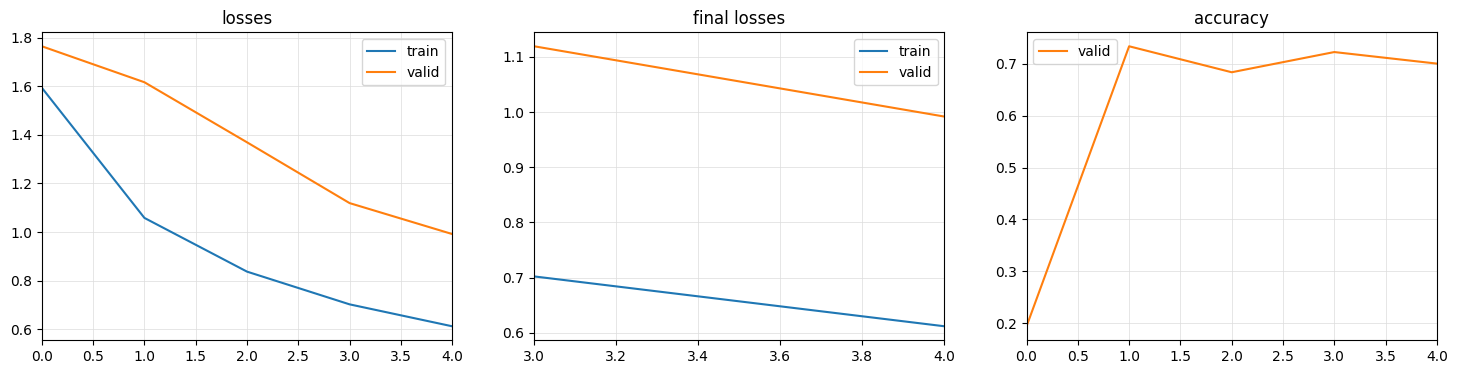

In [33]:
model = InceptionTimePlus(dls.vars, dls.c, nf=nf, fc_dropout=dropout_rate)
learn = Learner(dls, model, metrics=accuracy, cbs=FastAIPruningCallback(trial))

# New API
# learn = TSClassifier(X, y, splits=splits, bs=[64, 128], 
#                      batch_tfms=[TSStandardize()], metrics=accuracy,  
#                      arch=InceptionTimePlus, arch_config={'nf':nf, 'fc_dropout':dropout_rate})

learn.fit_one_cycle(5, lr_max=1e-3)
learn.plot_metrics()

For comparison our baseline model can only scored around 50% accuracy with 5 epochs training. However, using the hyperparameters from the Optuna study results in much higher accuracy. The numbers might vary due to the randomness in training. You can seed you runs or train the model a few times to verify the results. Happy learning! 